# Employee Attrition and Human Resource (HR) Analytics

The key to success in an organisation is the ability to attract and retain top talents. It is vital for the Human Resource (HR) Department to identify the factors that keep employees and those which prompt them to leave. Companies could do more to prevent the loss of good people.

This project is based on a fictional dataset downloaded from IBM HR Analytics Employee Attrition & Performance. It has 1,470 data points (rows) and 35 features (columns) describing each employee's background and characteristics; and labelled (supervised learning) with whether they are still in the company or whether they have gone to work somewhere else. Machine Learning models can help to understand and determine how these factors relate to workforce attrition.

Which are the key factors leading to employee attrition?

### Step 1: import relevant Python libraries, read in data


In [ ]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss
SEED = 42

In [ ]:
# data source: IBM HR Analytics Employee Attrition & Performance
# https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset
df = pd.read_csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")    # 1470 rows x 35 columns
df

### Step 2:  perform Exploratory Data Analysis (EDA)
These features come with the following label encoding:

* Education: 1 'Below College' 2 'College' 3 'Bachelor' 4 'Master' 5 'Doctor'
* EnvironmentSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
* JobInvolvement: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
* JobSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
* PerformanceRating: 1 'Low' 2 'Average' 3 'Good' 4 'Excellent' 5 'Outstanding'
* RelationshipSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
* WorkLifeBalance: 1 'Bad' 2 'Good' 3 'Better' 4 'Best'

In [ ]:
# data overview
print('Rows x Columns : ', df.shape[0], 'x', df.shape[1])
print('Features: ', df.columns.tolist())
print('\nUnique values:')
print(df.nunique())
for col in df.columns:
    print(col, ':', sorted(df[col].unique()))

In [ ]:
# type of data, how many missing values/null fields
df.info()
print('\nMissing values:  ', df.isnull().sum().values.sum())
df.isnull().sum()
# note: there is no missing data, dataset is quite clean

In [ ]:
# proportion of Attrition, class is imbalance
print(df.Attrition.value_counts())
print(df.Attrition.value_counts(normalize=True))
df['Attrition'].value_counts().plot('bar', color=('C0','C1')).set_title('Attrition')

#### Are employees leaving because they are poorly paid?

In [ ]:
# to plot employee distribution by HourlyRate, with distinct Attrition classes
# Average count of 20 employees in each HourlyRate class from 30 to 100
print(df.HourlyRate.value_counts().mean())
print(np.std(df.HourlyRate.value_counts()))
sns.axes_style('whitegrid')
sns.catplot('HourlyRate', data=df, aspect=3, kind='count', hue='Attrition', palette=['C1', 'C0']).set_ylabels('Number of Employees')

Both attrition classes have similar distribution as HourlyRate (they have similar mean and stdev). HourlyRate seems to have little effect on Attrition :

In [ ]:
# HourRate has a mean of 65.9 and stdev of 20.3
print(df.HourlyRate.mean())
print(np.std(df.HourlyRate))

In [ ]:
# to check mean & stdev of hourly rate for those Attrition=='No'
print(df[df.Attrition=='No']['HourlyRate'].mean())
print(np.std(df[df.Attrition=='No']['HourlyRate']))

In [ ]:
# to check mean & stdev of hourly rate for those Attrition=='Yes'
print(df[df.Attrition=='Yes']['HourlyRate'].mean())
print(np.std(df[df.Attrition=='Yes']['HourlyRate']))

#### Overtime seems to be a key factor to attrition

In [ ]:
# to plot employee distribution by OverTime, with distinct Attrition classes
sns.axes_style('whitegrid')
sns.factorplot("OverTime", data=df, aspect=1, kind='count', hue='Attrition', palette=['C1', 'C0']).set_ylabels('Number of Employees')

In [ ]:
# employees have background in these EducationField 
df.EducationField.value_counts()

In [ ]:
# to analyse JobRole in each Department
for dpmt in df['Department'].unique():
    print('\n', dpmt, ':')
    print(df[df['Department']==dpmt]['JobRole'].value_counts())

### Step 3: data preprocessing, label encoding, feature selection/engineering

In [ ]:
# to create new feature whether JobRole is related to EducationField, 0 = not related, 1 = related, 2 = somewhat related
# HR seems to have done fabulously in job matching as this feature did not emerge useful
df['EduField_Dept'] = 0
for i, row in df.iterrows():
    if row['EducationField']=='Human Resources' and row['Department']=='Human Resources':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Life Sciences' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Life Sciences' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Medical' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Medical' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Technical Degree' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Technical Degree' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Marketing' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 1
        
# for index, row in df.iterrows():
#     print(row['EducationField'], '->', row['Department'], '=>', row['EduField_Dept'])

In [ ]:
# to define new features (divide by something+1 to prevent division by zero)
df['Job_Coy'] = df['JobLevel'] / (df['YearsAtCompany'] + 1)
df['Edu_Age_TotalWorking'] = df['Education'] / (df['Age'] + df['TotalWorkingYears'])
df['CurrMgr_Coy'] = df['YearsWithCurrManager'] / (df['YearsAtCompany'] + 1)
df['CurrRole_CurrMgr'] = df['YearsInCurrentRole'] / (df['YearsWithCurrManager'] + 1)
# df

In [ ]:
# to check for categorical type columns and each unique values
for col in df.select_dtypes(['object']).columns:
    print(col, ':', sorted(df[col].unique()))

In [ ]:
# to drop useless features
df = df.drop(columns=['Over18', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'])

# label encoding to clean up categorical data
categorical_data = {
    'Attrition': {'No':0, 'Yes':1}, 
    'BusinessTravel': {'Non-Travel':0, 'Travel_Frequently':1, 'Travel_Rarely':2}, 
    'Department': {'Human Resources':0, 'Research & Development':1, 'Sales':2}, 
    'EducationField': {'Human Resources':0, 'Life Sciences':1, 'Marketing':2, 'Medical':3, 'Technical Degree':4, 'Other':5}, 
    'Gender': {'Female':0, 'Male':0}, 
    'JobRole': {'Healthcare Representative':0, 'Human Resources':1, 'Laboratory Technician':2, 'Manager':3, 'Manufacturing Director':4, 'Research Director':5, 'Research Scientist':6, 'Sales Executive':7, 'Sales Representative':8}, 
    'MaritalStatus': {'Divorced':0, 'Single':1, 'Married':2}, 
    #'Over18': {'Y':1}, 
    'OverTime': {'No':0, 'Yes':1}    }
df = df.replace(categorical_data)
df

In [ ]:
# define feature X and target y dataset (X and y are commonly used in sklearn)
X, y = df.drop('Attrition', axis=1), df['Attrition']

# use RandomForestClassifier to look for important key features
n = 10    # specify n (top n features)
rfc = RandomForestClassifier(random_state=SEED, n_estimators=200, max_depth=3)
rfc_model = rfc.fit(X, y)
pd.Series(rfc_model.feature_importances_, index=X.columns).nlargest(n).plot(kind='barh', 
    figsize=[8, n/3], color='navy').invert_yaxis()    # most important feature is on top, ie, descending order
ticks_x = np.linspace(0, 0.2, 5)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=15, color='black')
plt.yticks(size=15, color='navy' )
plt.title('Top Features derived by RandomForestClassifier', family='fantasy', size=15)
top10_features = pd.Series(rfc_model.feature_importances_, index=X.columns).nlargest(10)
print('Top 10 Features:', list(top10_features.index))

# check for correlation between top 10 features
X = df.loc[:, top10_features.index]
y = df['Attrition']
df_top10 = X.join(y)
# correlation matrix heatmap visualization
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(df_top10.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(9,9))
# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255
# Plot the heatmap
sns.heatmap(df_top10.corr().round(2), mask=mask, annot=True, annot_kws={"size": 12}, square=True, 
            cmap=cmap , vmin=-1, vmax=1, ax=ax)  # annot=True display corr label
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

In [ ]:
# drop highly correlated features: JobLevel & MonthlyIncome = 0.95 (JobLevel has lower feature importance)
df = df.drop(columns=['JobLevel'])

In [ ]:
# re-run correlation matrix heatmap: TotalWorkingYears & MonthlyIncome = 0.77, YearsWithCurrManager & YearsAtCompany = 0.77
df = df.drop(columns=['TotalWorkingYears', 'YearsWithCurrManager'])

In [ ]:
# re-run correlation matrix heatmap: YearsInCurrentRole & YearsAtCompany = 0.76
df = df.drop(columns=['YearsInCurrentRole'])

In [ ]:
# re-run correlation matrix heatmap: YearsAtCompany & MonthlyIncome = 0.51
df = df.drop(columns=['YearsAtCompany'])

In [ ]:
# re-run correlation matrix heatmap: Age & MonthlyIncome = 0.5
df = df.drop(columns=['Age'])

In [ ]:
# to visualise pair plot of top 10 features
sns.pairplot(df_top10, hue='Attrition', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

In [ ]:
# analyse feature-outcome distribution in visualisation
features = list(top10_features.index)[0:8]   # visualise only the top 8 features

ROWS, COLS = 2, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18,8) )
row, col = 0, 0
for i, feature in enumerate(features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    
#     df[feature].hist(bins=35, color='green', alpha=0.5, ax=ax[row, col]).set_title(feature)  #show all, comment off below 2 lines
    df[df.Attrition==0][feature].hist(bins=35, color='blue', alpha=0.5, ax=ax[row, col]).set_title(feature)
    df[df.Attrition==1][feature].hist(bins=35, color='orange', alpha=0.7, ax=ax[row, col])
    
plt.legend(['No Attrition', 'Attrition'])
fig.subplots_adjust(hspace=0.3)

### Step 4: split data into 80:20 ratio, use cross validation to perform baseline model selection

Specify parameter "stratify=y" in the code so that the proportion of classes in the output dataset will have the same proportion as the stratify column provided. As target y has binary categorical classes with 84% '0's and 16% '1's, "stratify=y" will make sure that the 80:20 split has 84% of '0's and 16% of '1's in both output datasets. 

Reference : http://www.kmdatascience.com/2017/07/k-folds-cross-validation-in-python.html

Cross Validation: use StratifiedKFold, as target class is imbalance. 

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

In [ ]:
# define feature X and target y dataset (X and y are commonly used in sklearn)
X, y = df.drop('Attrition', axis=1), df['Attrition']
print('X', X.shape, 'y', y.shape)

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

# kf = KFold(n_splits=5, shuffle=True, random_state=SEED)   # this may result in imbalance classes in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)   # use this

In [ ]:
# # To explore: Scaling Numerical columns
# from sklearn.preprocessing import MinMaxScaler, StandardScaler   # not much difference in results
# # scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range = (0,1))
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

### Step 5: optimise model: hyperparameter tuning

In [ ]:
## BASELINE model performance evaluation
# to define which metric and model to use
met = {'accuracy':True, 'precision':True, 'recall':True, 'f1score':True, 'rocauc':True, 'logloss':True}
mod = {'gnb':True, 'bnb':True, 'mnb':True, 'logr':True, 'knn':True, 'dt':True, 'rf':True, 'xgb':False, 'svc':True, 'lsvc':True}

# to give model baseline performance report in dataframe 
def metric(model, X_train, X_test, y_train, y_test, name):
    accuracy1 = accuracy2 = precision = recall = f1score = rocauc = logloss = 0.0
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if met['accuracy']:
        accuracy1 = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
        accuracy2 = accuracy_score(y_test, y_pred)
    if met['precision']: precision = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
    if met['recall']:    recall    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
    if met['f1score']:   f1score   = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))
    if met['rocauc']:    rocauc    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc'))
    if met['logloss']:   logloss   = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    return pd.DataFrame({'model'    : [name],
                         'accuracy' : [accuracy1],
                         'acc(test)': [accuracy2],
                         'precision': [precision],
                         'recall'   : [recall],
                         'f1score'  : [f1score],
                         'rocauc'   : [rocauc],
                         'logloss'  : [logloss],
                         'timetaken': [0.0]       })   # timetaken: to be used for comparison later

# to initialise an empty dataframe
rpt = pd.DataFrame({'model'    : [],
                    'accuracy' : [],
                    'acc(test)': [],
                    'precision': [],
                    'recall'   : [],
                    'f1score'  : [],
                    'rocauc'   : [],
                    'logloss'  : [],
                    'timetaken': []       })

# to initialise all baseline models
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
logr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
svc = SVC()
lsvc = LinearSVC()

if mod['gnb']:  rpt = pd.concat([rpt, metric(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')])   # default axis=0
if mod['bnb']:  rpt = pd.concat([rpt, metric(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB')])
if mod['mnb']:  rpt = pd.concat([rpt, metric(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')])
if mod['logr']: rpt = pd.concat([rpt, metric(logr, X_train, X_test, y_train, y_test, 'LogisticRegression')])
if mod['knn']:  rpt = pd.concat([rpt, metric(knn, X_train, X_test, y_train, y_test, 'KNearestNeighbour')])
if mod['dt']:   rpt = pd.concat([rpt, metric(dt, X_train, X_test, y_train, y_test, 'DecisionTree')])
if mod['rf']:   rpt = pd.concat([rpt, metric(rf, X_train, X_test, y_train, y_test, 'RandomForest')])
if mod['xgb']:  rpt = pd.concat([rpt, metric(xgb, X_train, X_test, y_train, y_test, 'XGBoost')])
if mod['svc']:  rpt = pd.concat([rpt, metric(svc, X_train, X_test, y_train, y_test, 'SVC')])
if mod['lsvc']: rpt = pd.concat([rpt, metric(lsvc, X_train, X_test, y_train, y_test, 'LinearSVC')])
rpt = rpt.reset_index(drop=True)
display(rpt)

## TUNED model performance evaluation
def tuning(model, X_train, X_test, y_train, y_test, name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                   np.linspace(optimal_th-0.1,    optimal_th+0.1,    21), 
                   np.linspace(optimal_th-0.01,   optimal_th+0.01,   21)]
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print('\n', name, 'accuracy score is')
    accuracy1 = model.score(X_train, y_train)   # .score uses accuracy
    print('Training: {:.2f}%'.format(100*accuracy1))
    accuracy2 = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy2))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('Default threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('Adjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(name, 'Log-loss: {:.4f}'.format(logloss))

    return pd.DataFrame({'model'    : [name],
                         'accuracy' : [accuracy1],
                         'acc(test)': [accuracy2],
                         'precision': [precision],
                         'recall'   : [recall],
                         'f1score'  : [f1score],
                         'rocauc'   : [rocauc],
                         'logloss'  : [logloss],
                         'timetaken': [1000]       })   # timetaken: to be used for comparison late

# to initialise an empty dataframe
tuned = pd.DataFrame({'model'    : [],
                    'accuracy' : [],
                    'acc(test)': [],
                    'precision': [],
                    'recall'   : [],
                    'f1score'  : [],
                    'rocauc'   : [],
                    'logloss'  : [],
                    'timetaken': []       })

if mod['gnb']:
    print('\n"""""" GaussianNB """"""')
    time1 = time.time()
    gnb = GaussianNB()
    model_tuned = tuning(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0

if mod['bnb']:
    print('\n"""""" BernoulliNB """"""')
    time1 = time.time()
    bnb = BernoulliNB()
    model_tuned = tuning(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0

if mod['mnb']:
    print('\n"""""" MultinomialNB """"""')
    time1 = time.time()
    mnb = MultinomialNB()
    model_tuned = tuning(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0

if mod['logr']:
    print('\n"""""" LogisticRegression """"""')
    time1 = time.time()
    print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold CV on train data')
    score_list = []
    c_list = 10**np.linspace(-3,3,200)
    for c in c_list:
        logr = LogisticRegression(C = c)
        cvs = (cross_val_score(logr, X_train, y_train, cv=kf, scoring='f1')).mean()
        score_list.append(cvs)
        print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
    print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
    optimal_c = float(c_list[score_list.index(max(score_list))])
    print('optimal value of C = {:.3f}'.format(optimal_c))
    logr = LogisticRegression(C = optimal_c)
    model_tuned = tuning(logr, X_train, X_test, y_train, y_test, 'LogisticRegression')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    
if mod['knn']:
    print('\n"""""" KNN """""" ')
    time1 = time.time()
    print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold CV on train data')
    k_scores = []
    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors = k)
        cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
        k_scores.append(cvs)
        print('{:.4f}'.format(cvs), end=", ")
    print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
    optimal_k = k_scores.index(max(k_scores)) + 1   # index 0 is for k=1
    print('optimal value of K =', optimal_k)
    knn = KNeighborsClassifier(n_neighbors = optimal_k)
    model_tuned = tuning(knn, X_train, X_test, y_train, y_test, 'KNearestNeighbour')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    
if mod['dt']:
    print('\n"""""" DecisionTreeClassifier """"""')
    time1 = time.time()
    print('\nSearch for optimal max_depth in DecisionTree, vary from 2 to 10, using KFold CV on train data')
    d_scores = []
    for d in range(2, 11):
        dt = DecisionTreeClassifier(max_depth=d, random_state=SEED)
        cvs = cross_val_score(dt, X_train, y_train, cv=kf, scoring='f1').mean()
        d_scores.append(cvs)
        print('{:.4f}'.format(cvs), end=", ")
    print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
    optimal_d = d_scores.index(max(d_scores)) + 2   # index 0 is for d=2
    print('optimal max_depth =', optimal_d)
    dt = DecisionTreeClassifier(max_depth=optimal_d, random_state=SEED)
    model_tuned = tuning(dt, X_train, X_test, y_train, y_test, 'DecisionTree')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    # Note: results keep changing in each run
    
if mod['rf']:
    print('\n"""""" RandomForestClassifier """""" (quite slow)')
    time1 = time.time()
    print('\nSearch for optimal n_estimators in RandomForest, vary from 100 to 500, using KFold CV on train data')
    score_list = []
    n_list = [100, 150, 200, 250, 300, 350, 400, 450, 500]
    for n in n_list:
        rf = RandomForestClassifier(n_estimators=n)
        cvs = (cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1')).mean()
        score_list.append(cvs)
        print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    optimal_n = int(n_list[score_list.index(max(score_list))])
    print('optimal n_estimators = {:.0f}'.format(optimal_n))
    rf = RandomForestClassifier(n_estimators=optimal_n)
    model_tuned = tuning(rf, X_train, X_test, y_train, y_test, 'RandomForest')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    # Note: results keep changing in each run
    
if mod['xgb']:
    print('\n"""""" XGBClassifier """""" (quite slow)')
    time1 = time.time()
    print('\nSearch for optimal n_estimators in XGBClassifier, vary from 100 to 500, using KFold CV on train data')
    score_list = []
    n_list = [100, 150, 200, 250, 300, 350, 400, 450, 500]
    for n in n_list:
        xgb = XGBClassifier(n_estimators=n)
        cvs = (cross_val_score(xgb, X_train, y_train, cv=kf, scoring='f1')).mean()
        score_list.append(cvs)
        print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    optimal_n = int(n_list[score_list.index(max(score_list))])
    print('optimal n_estimators = {:.0f}'.format(optimal_n))
    print('\nSearch for optimal max_depth in XGBClassifier, vary from 2 to 10, using KFold CV on train data')
    d_scores = []
    for d in range(2, 11):
        xgb = XGBClassifier(n_estimators=optimal_n, max_depth=d)
        cvs = cross_val_score(xgb, X_train, y_train, cv=kf, scoring='f1').mean()
        d_scores.append(cvs)
        print('{:.4f}'.format(cvs), end=", ")
    print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
    optimal_d = d_scores.index(max(d_scores)) + 2   # index 0 is for d=2
    print('optimal max_depth =', optimal_d)
    xgb = XGBClassifier(n_estimators=optimal_n, max_depth=optimal_d)
    model_tuned = tuning(xgb, X_train, X_test, y_train, y_test, 'XGBoost')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    
if mod['svc']:
    print('\n"""""" SVC """"""')
    time1 = time.time()
    svc = SVC(gamma='scale', probability=True)
    model_tuned = tuning(svc, X_train, X_test, y_train, y_test, 'SVC')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    
if mod['lsvc']:
    print('\n"""""" LinearSVC """"""')
    time1 = time.time()
    lsvc = LinearSVC()    # model has no attribute 'predict_proba'
    lsvc.fit(X_train, y_train)
    print('LinearSVC accuracy score is')
    accuracy1 = lsvc.score(X_train, y_train)   # .score uses accuracy
    print('Training: {:.2f}%'.format(100*accuracy1))
    accuracy2 = lsvc.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy2))
    y_pred = lsvc.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred) 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    logloss      = log_loss(y_test, y_pred)
    print('LinearSVC AUC: {:.4f}'.format(rocauc))
    print('LinearSVC Log-loss: {:.4f}'.format(logloss))
    tuned = pd.concat([tuned, pd.DataFrame({'model'    : ['LinearSVC'],
                                            'accuracy' : [accuracy1],
                                            'acc(test)': [accuracy2],
                                            'precision': [precision],
                                            'recall'   : [recall],
                                            'f1score'  : [f1score],
                                            'rocauc'   : [rocauc],
                                            'logloss'  : [logloss],
                                            'timetaken': [time.time() - time1] }) ])   # default axis=0
tuned = tuned.reset_index(drop=True)

### Compiling the results of all tuned models

In [ ]:
print('Baseline model performance:')
display(rpt)
print('After tuning hyperparameters:')
display(tuned)

# initialise an empty df for comparison: 1 = improved, 0 = no improvement
print('Comparison: 1 = improved, 0 = no improvement')
n = rpt.shape[0]
df_compare = pd.DataFrame({'model':[0]*n, 'accuracy':[0]*n, 'acc(test)':[0]*n, 'precision':[0]*n, 'recall':[0]*n,
                           'f1score':[0]*n, 'rocauc':[0]*n, 'logloss':[0]*n, 'timetaken':[0]*n})
df_compare.model = rpt.model
for i in range(1,7):
    for j in range(n):
        if tuned[tuned.columns[i]][j] >= rpt[rpt.columns[i]][j]:
            df_compare[df_compare.columns[i]][j] = 1
for i in range(7,9):
    for j in range(n):
        if tuned[tuned.columns[i]][j] <= rpt[rpt.columns[i]][j]:
            df_compare[df_compare.columns[i]][j] = 1
display(df_compare)

Final model performance
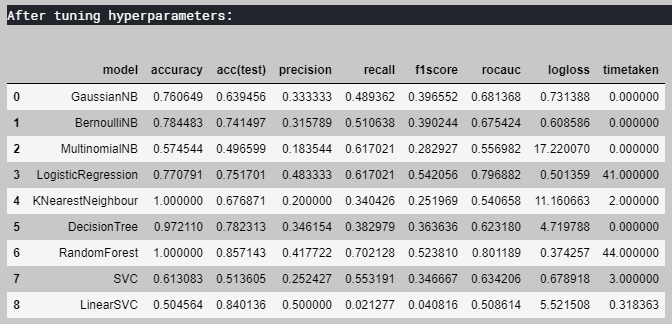

In [ ]:
## plot the performance metric scores
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(tuned.model, tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(tuned.model, tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(tuned.model, tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(tuned.model, tuned.timetaken)
ax[3].set_title('Time taken')

# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

In [ ]:
# plot the ROC curves
plt.figure(figsize=(10,10))

# model_name = [gnb, bnb, mnb, logr, knn, dt, rf, xgb, svc, lsvc]
model_name = [gnb, bnb, mnb, logr, knn, dt, rf, svc, lsvc]

for i in range(len(model_name)-1):
    y_pred = model_name[i].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

y_pred = lsvc.predict(X_test)   # linearsvc has no attribute 'predict_proba'
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='LinearSVC (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [ ]:
# see how model confusion matrix varies with threshold
bestmodel = rf

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (bestmodel.predict(X_test) is done automatically with a threshold of 0.5)
    y_pred = (bestmodel.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no attrition', 'attrition'],
           yticklabels=['no attrition', 'attrition']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
# Let's see how the confusion matrix changes with changes to the threshold 
from ipywidgets import interactive, FloatSlider
# bestmodel = LogisticRegression(C = optimal_c)
# bestmodel.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(bestmodel, threshold), threshold=(0.0,1.0,0.01))

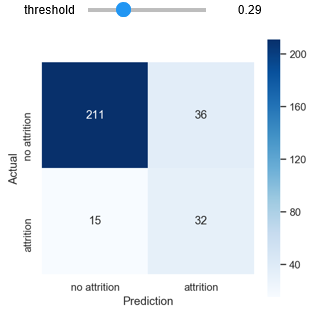

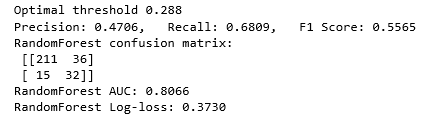

### The winning model
In general for the winning model, both Recall and F1-score metrics have improved after tuning.

Iteration 1, baseline with tuning: LogisticRegression, with the highest F1-score 50.5% and Recall 48.9%

Iteration 2, added new features (feature engineering): RandomForest F1-score 49.6% and Recall 61.7%

Iteration 3, with SMOTE over-sampling: RandomForest F1-score 52.4% and highest Recall 70.2%

### Appendix: To handle imbalance data
This two-class dataset is imbalanced (84% vs 16%). As a result, there is a possibility that the model built might be biased towards to the majority and over-represented class. After applying Synthetic Minority Oversampling Technique (SMOTE) to over-sample the minority class, some improvement in both F1-score & Recall can be observed.

In [ ]:
# to check if over-sampling can improve the model performance (not for XGBoost)
bestmodel = rf

# baseline model performance (before over-sampling)
print('(Original) Baseline X_train.shape:', X_train.shape)
print(pd.value_counts(pd.Series(y_train)))
bestmodel.fit(X_train, y_train)
y_pred = bestmodel.predict(X_test)
print('Model accuracy is', accuracy_score(y_test, y_pred))
print('Model accuracy is', bestmodel.score(X_test, y_test))   # same result (.score uses accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# re-run model with resampled data using SMOTE over-sampling
# handling imbalance data: create fake sample data to add to the minority class to balance it out.
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
print('\nAfter SMOTE over-sampling X_train_sm.shape:', X_train_sm.shape)
print(pd.value_counts(pd.Series(y_train_sm)))
bestmodel_sm = bestmodel.fit(X_train_sm, y_train_sm)
y_pred = bestmodel_sm.predict(X_test)
print('Model accuracy is', accuracy_score(y_test, y_pred))
print('Model accuracy is', bestmodel_sm.score(X_test, y_test))   # same results (.score uses accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
# run SMOTE and this cell, then re-run baseline model performance and tuned model performance (long bunch of code)
# have to turn off XGBoost (after over-sampling)
X_train = X_train_sm
y_train = y_train_sm